### Introduction to Topological Signal Compression

In [1]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
from tsc import signal_persistence, compress_tsc, reconstruct_tsc
from tsc.utils.viz import plot_persistence

<div class="alert alert-info">
    Note: the <code>tsc.utils</code> module does not install its dependencies by default; you must install <code>topological-signal-compression[extras]</code> to include these dependencies in your installation.
</div>

Topological Signal Compression (TSC) is a topology-based lossy compression methodology for 1-dimensional signals.

#### Benefits of TSC

Before getting into the mathematical justification for TSC, there are several benefits of TSC worth explicitly noting:

**Signal Agnostic** &ndash; TSC can work for arbitary signal types (sound, sensors, etc).

The tuning parameter is **highly-interpretable**; one simply asks for less points when compressing more.

**The resulting compressed signal is a subset of the original data**. Many compression methods (for example Fourier methods) reconstruct an *approximation* of the original signal. TSC allows one to maintain the raw (time, magnitude) pairs in the compressed signal.

**A marginal increase in compression compresses locally**. In other words, if we tweak our compression to only drop a few more points, then we *only* compress the shape of the signal locally around those dropped points, leaving the rest of the signal unchanged. This is theoretically nice for maintaining comparable signals when transmitting under a variable communications budget.

**Built to de-noise** &ndash; if trying to drop smaller noise values from the signal, this definitionally works well by running TSC where one removes pairs of critical points with sufficiently low persistence (we discuss persistence in more detail below).

#### Toy Example

To demonstrate the basic mathematical motivation behind Topological Signal Compression (TSC), we will use the simple signal shown below.

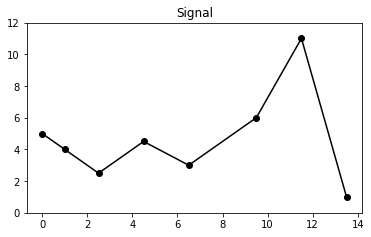

In [2]:
data = np.array([
    [ 0. ,  5. ],
    [ 1. ,  4. ],
    [ 2.5,  2.5],
    [ 4.5,  4.5],
    [ 6.5,  3. ],
    [ 9.5,  6. ],
    [11.5, 11. ],
    [13.5,  1. ]
])

bounds = (0, 12)

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.plot(data[:, 0], data[:, 1], c="black")
ax.scatter(data[:, 0], data[:, 1], c="black")
ax.set_title("Signal")

ax.set_ylim(bounds[0], bounds[1])
plt.show()

#### Persistent Homology

A signal $f$ can be summarized by its zero-dimensional persistence diagram. Intuitively, one need only understand the following in the context of a signal. Here, persistent homology tracks connected components as we sweep a horizontal line vertically from negative infinity to positive infinity. Components are born at local minima, and die at local maxima, destroying the more recently born component of the two components merging. The persistence diagram plots the births and deaths of components as dots in the plane. The
vertical distance of a dot above the 45 degree line birth = death represents the persistence of a component within the filtration. See the below figure for an example of a signal and its corresponding persistence diagram.

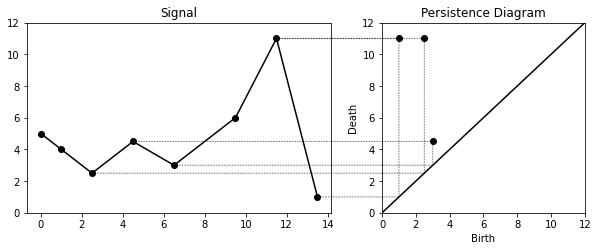

In [3]:
# run signal persitence
pers = signal_persistence(signal=data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5),
                               gridspec_kw={'width_ratios': [6., 4.]})

ax1.plot(data[:, 0], data[:, 1], c="black")
ax1.scatter(data[:, 0], data[:, 1], c="black")
ax1.set_title("Signal")

# plot persistence values
plot_persistence(pers,
                 bounds=bounds,
                 c='black',
                 fig=fig, ax=ax2, alpha=1)

# line up figures
ax1.set_ylim(bounds[0], bounds[1])

# signal point will be at death index
cons = []
for i in range(pers.shape[0]):
    
    # death line
    xyA = data[pers.death_index.values[i], :]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2,
                          color="black", ls="dotted", alpha=0.5)
    cons.append(con)
    
    # birth line
    xyA = data[pers.birth_index.values[i], :]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i] - pers.pers[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2,
                          color="black", ls="dotted", alpha=0.5)
    cons.append(con)
    
    # vertical connectors
    xyA = [pers.birth.values[i], pers.death.values[i] - pers.pers[i]]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax2,
                          color="black", ls="dotted", alpha=0.5)
    cons.append(con)
    
    

[ax2.add_artist(con) for con in cons]

plt.show()

<div class="alert alert-info">
    Note, we are following the convention of pairing the global min with the global max.
</div>

The creation of this persistence diagram can also be visualized dynamically in the below figure. For more discussion on this, see the "Signals" section of this [Towards Data Science article on persistent homology](https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0).

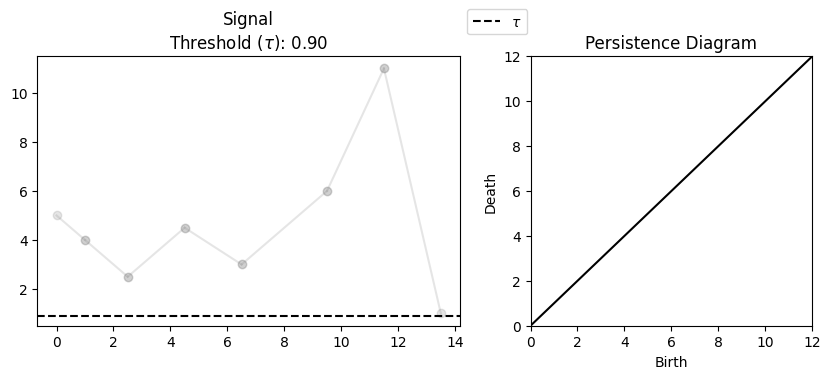

<div class="alert alert-info">
    This figure was produced by the <code>./runners/signal_sweep.py</code> script in the TSC repository.
</div>

#### Minimum Compression with TSC

In tracking the births and deaths of components, we inherently only track the *critical points* in a signal. Thus, the *minimum compression* performed by TSC is to drop all non-critical points, as exemplified with our original signal, shown reconstructed in the figure below.

In [4]:
fig, ax = plt.subplots(figsize=(6, 3.5))

# run minimal TSC compression, keeping only critical points
data_all_pers_values = compress_tsc(data, num_indices_to_keep="all")

ax.plot(data_all_pers_values[:, 0], data_all_pers_values[:, 1],
        c="black", label="Reconstructed\nSignal")
ax.scatter(data_all_pers_values[:, 0], data_all_pers_values[:, 1],
           c="black", zorder=1)

# plot original signal for reference
ax.plot(data[:, 0], data[:, 1], c="red",
        alpha=0.6, ls="--", label="Original\nSignal", zorder=-1)
ax.scatter(data[:, 0], data[:, 1], c="red", alpha=0.6, zorder=-1)

ax.set_title("Signal Reconstructed From All Persistence Values")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

<div class="alert alert-info">
Note that we have implicitly assumed a linear connection in between points on the reconstructed signal. One could also connect the points with any desired monotonic function.
</div>

#### "Unkinking" with the Morse Cancellation Lemma (MCL)

The theoretical force behind the algorithm is the Morse Cancellation Lemma (MCL). The MCL guarantees that the dot of lowest persistence corresponds to a pair of horizontally adjacent critical points in the time domain. This therefore guarantees that unkinking that pair of critical points will not unkink any other pair.

Persistent homology gives us an order on our critical points&mdash;dots on the persistence diagram that are close to the diagonal die soon after being born. By allowing us to identify low-persistence components, persistent homology shows us the parts of the signal most likely corresponding to noise.

Thanks to the MCL, TSC enables the reconstruction of a signal as it would be without the value of least persistence, thus keeping the more prominent features of the signal.

We demonstrate this unkinking by removing the pair of critical points corresponding to the lowest persistence value in the figure below.

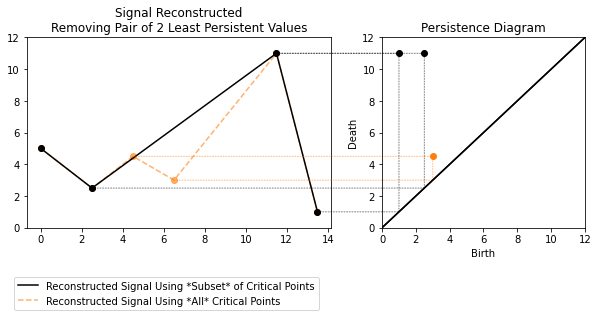

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5),
                               gridspec_kw={'width_ratios': [6., 4.]})

# run minimal TSC compression, keeping *subset* of critical points
data_some_pers_values = compress_tsc(data, num_indices_to_keep=4)

ax1.plot(data_some_pers_values[:, 0], data_some_pers_values[:, 1],
         c="black",
         label="Reconstructed Signal Using *Subset* of Critical Points")
ax1.scatter(data_some_pers_values[:, 0], data_some_pers_values[:, 1],
            c="black", zorder=1)

# plot TSC compression with *all* critical points for reference
ax1.plot(data_all_pers_values[:, 0], data_all_pers_values[:, 1],
         c="C1", alpha=0.6, ls="--", zorder=-1,
         label="Reconstructed Signal Using *All* Critical Points")
ax1.scatter(data_all_pers_values[:, 0], data_all_pers_values[:, 1],
            c="C1", alpha=0.6, zorder=-1)

ax1.set_title("Signal Reconstructed\nRemoving Pair of 2 Least Persistent Values")

fig.legend(loc="upper left", bbox_to_anchor=(0.1, -0.05))

# plot persistence values, but plot dropped pers value differently
plot_persistence(pers.iloc[1:, :],
                 bounds=bounds,
                 c='black',
                 fig=fig, ax=ax2, alpha=1)
plot_persistence(pers.iloc[0, :],
                 bounds=bounds,
                 c='C1',
                 fig=fig, ax=ax2, alpha=1)

# line up figures
ax1.set_ylim(bounds[0], bounds[1])

# signal point will be at death index
cons = []
for i in range(pers.shape[0]):
    # plot the connections to the dropped pers value a different color
    if i == 0:
        color="C1"
    else:
        color="black"
    
    # death line
    xyA = data[pers.death_index.values[i], :]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2,
                          color=color, ls="dotted", alpha=0.5)
    cons.append(con)
    
    # birth line
    xyA = data[pers.birth_index.values[i], :]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i] - pers.pers[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2,
                          color=color, ls="dotted", alpha=0.5)
    cons.append(con)
    
    # vertical connectors
    xyA = [pers.birth.values[i], pers.death.values[i] - pers.pers[i]]
    # corresponding pers value will be it's birth and death
    xyB = [pers.birth.values[i], pers.death.values[i]]
    con = ConnectionPatch(xyA=xyA, xyB=xyB,
                          coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax2,
                          color=color, ls="dotted", alpha=0.5)
    cons.append(con)
    
    

[ax2.add_artist(con) for con in cons]

plt.show()

plt.show()

We can of course still keep track of our reconstruction relative to the original signal.

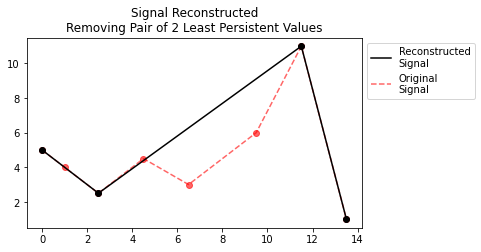

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.5))

# run minimal TSC compression, keeping only critical points
new_data = compress_tsc(data, num_indices_to_keep=4)

ax.plot(new_data[:, 0], new_data[:, 1], c="black",
        label="Reconstructed\nSignal")
ax.scatter(new_data[:, 0], new_data[:, 1], c="black", zorder=1)

# plot original signal for reference
ax.plot(data[:, 0], data[:, 1], c="red",
        alpha=0.6, ls="--", label="Original\nSignal", zorder=-1)
ax.scatter(data[:, 0], data[:, 1], c="red", alpha=0.6, zorder=-1)

ax.set_title("Signal Reconstructed\nRemoving Pair of 2 Least Persistent Values")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

#### Iterating the MCL

The MCL can be applied iteratively, allowing for arbitrary compression of a given signal. Here we include a quick dynamic visualization of TSC on a larger toy signal.

We start with a random walk-based signal.

Compressing this to only the critical points (e.g. `tsc.compress_tsc(..., num_indices_to_keep="all")`), we still maintain a very similar signal.

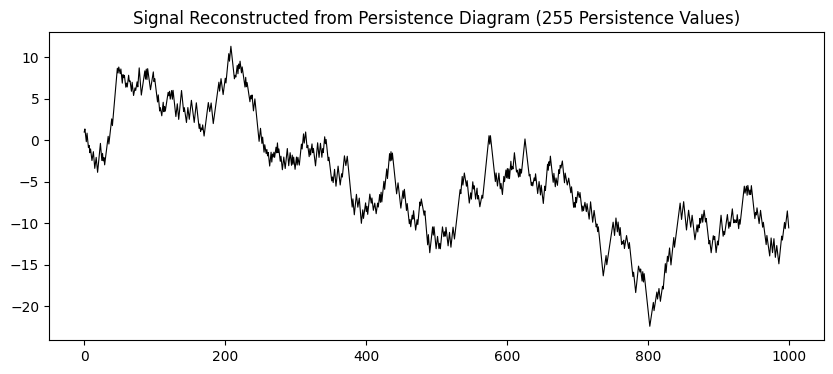

By iteratively unkinking the lowest persistence pair of points, we can increasingly simplify the signal.

<div class="alert alert-info">
    These figures were produced by the <code>./runners/compression_toy_example.py</code> script in the TSC repository.
</div>

We demonstrate the iterative compression on a real-world example in the [Free-Spoken Digit Dataset notebook](https://geomdata.gitlab.io/topological-signal-compression/fsdd.html).

#### References

[1] J. W. Milnor, Morse Theory. Princeton University Press, 1963.

[2] F. Laudenbach, “A proof of morse’s theorem about the cancellation of critical points,” Comptes Rendus de l’Academie des Sciences, pp. 483–488, 2013.

[3] U. Bauer, C.-B. Schönlieb, and M. Wardetzky, “Total variation meets topological persistence: A first encounter,” in AIP Conference Proceedings, vol. 1281, pp. 1022–1026, American Institute of Physics, 2010.

[4] H. Edelsbrunner, D. Morozov, and V. Pascucci, “Persistence-sensitive simplification functions on 2-manifolds,” in Proceedings of the twenty-second annual symposium on Computational geometry, pp. 127–134, 2006.